In [182]:
!nvidia-smi

Fri Sep 15 11:59:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:AF:00.0 Off |                  N/A |
| 42%   79C    P2   228W / 250W |  10446MiB / 11019MiB |     66%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:D8:00.0 Off |                  N/A |
| 27%   

In [183]:
import os
import shutil
import scipy
from scipy import stats
from skimage.io import imread, imsave
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [3]:
save=True #for saving the output segmented images

In [184]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [185]:
scipy.__version__

'1.10.1'

In [186]:
weights_path='/M28/Bhumika_Logs_gpu1/nissl20230811T0849/mask_rcnn_nissl_1500.h5'

In [187]:
imgdir='/data/Devel_Human/LAB_Images'
maskdir='/data/Devel_Human/GTmasks'

In [188]:
A=os.listdir(imgdir)
A.sort()
image_list=A

mask_list=[]
for i in image_list:
    mask_list.append(i.split('.')[0]+'.tif')

In [189]:
def add_masks_to_dict(image_id,mask,out_mk=True):
    #mask has the shape of (ht,wd,instances) i.e. before combining the instances
    if out_mk:
        output_result[str(image_id)]=mask
    else:
        gt_dict[str(image_id)]=mask
    

In [190]:
from skimage.segmentation import (
    watershed, relabel_sequential, 
    find_boundaries
)
from skimage import measure
import scipy
from skimage.feature import peak_local_max
def label_watershed(fgmask):
    
    distance = scipy.ndimage.distance_transform_edt(fgmask)
    coords = peak_local_max(distance, min_distance=4, footprint=np.ones((5, 5)))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = scipy.ndimage.label(mask)
    return watershed(-distance, markers, mask=fgmask)

# def load_mask(image_id):
#     """Generate instance masks for an image.
#    Returns:
#     masks: A bool array of shape [height, width, instance count] with
#         one mask per instance.
#     class_ids: a 1D array of class IDs of the instance masks.
#     """
# #     info = self.image_info[image_id]
#     # Get mask directory from image path
# #     mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "GTmasks")
#     import skimage.io
#     big_o=[]
#     cell_masks = []

#     m = skimage.io.imread(os.path.join(maskdir, "%s.tif"%str(image_id)),plugin='pil').astype(np.uint8)
#     msk_lbl = measure.label(m==255)
#     props = measure.regionprops_table(msk_lbl,m,properties=('label','area','bbox_area'))
#     big_o = props['label'][np.where(props['area']>100)]
# #     small_o = props['label'][np.where(props['area']<10)]

#     for jj in range(1,msk_lbl.max()+1):
# #         if jj not in small_o:
#         if jj not in big_o:
#             cell_masks.append(msk_lbl==jj)

#         else:
#             # split            
#             newlbl = label_watershed(msk_lbl==jj)
#             for ll in range(1,newlbl.max()+1):
#                 cell_masks.append(newlbl==ll) 

#     mask = np.dstack(cell_masks)

#     return mask, np.ones([mask.shape[-1]], dtype=np.int32)


# def load_mask(image_id):
#         """Generate instance masks for an image.
#        Returns:
#         masks: A bool array of shape [height, width, instance count] with
#             one mask per instance.
#         class_ids: a 1D array of class IDs of the instance masks.
#         """
#         import skimage.io
#         big_o=[]
#         cell_masks = []

#         m = skimage.io.imread(os.path.join(maskdir, "%s.tif"%str(image_id)),plugin='pil').astype(np.uint8)
#         msk_lbl = measure.label(m==255)
#         props = measure.regionprops_table(msk_lbl,m,properties=('label','area','bbox_area'))
#         big_o = props['label'][np.where(props['area']>130)]
#         small_o = props['label'][np.where(props['area']<10)]
#         for jj in range(1,msk_lbl.max()+1):
#             if jj not in small_o:
#                 if jj not in big_o:
#                     cell_masks.append(msk_lbl==jj)
#                     pass

#                 else:
#             #         split            
#                     newlbl = label_watershed(msk_lbl==jj)
#                     for ll in range(1,newlbl.max()+1):
#                         props = measure.regionprops_table((newlbl==ll)*1,newlbl,properties=('label','area','bbox_area'))
#                         if props['area']<16:
#                             pass
#                         else:
#                             cell_masks.append(newlbl==ll)
#         mask = np.dstack(cell_masks)
#         return mask, np.ones([mask.shape[-1]], dtype=np.int32)

def load_mask(image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        import skimage.io
        big_o=[]
        cell_masks = []

        m = skimage.io.imread(os.path.join(maskdir, "%s.tif"%str(image_id)),plugin='pil').astype(np.uint8)

        msk_lbl = measure.label(m==255)
        props = measure.regionprops_table(msk_lbl,m,properties=('label','area','bbox_area'))
    #     big_o = props['label'][np.where(props['area']>130)]
        small_o = props['label'][np.where(props['area']<10)]

        for jj in range(1,msk_lbl.max()+1):
            if jj not in small_o:
    #             if jj not in big_o:
                cell_masks.append(msk_lbl==jj)

            else:
                continue
        mask = np.dstack(cell_masks)
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

In [191]:
import sys
sys.path.append('../..')
from mrcnn.utils import extract_bboxes,compute_overlaps,compute_overlaps_masks
def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
#     print(iou_threshold)
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
#     # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
#     print(pred_match.shape)
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids == gt_class_ids:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
#                 print(pred_match[i])
                break

    return gt_match, pred_match, overlaps


In [192]:
def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Get matches and overlaps
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_threshold)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps



In [193]:
def calculate_matching_ids_(masks1, masks2, threshold=0.0001):
    """
    Calculates the matching instance IDs based on intersection area between masks.
    Each instance of one mask is uniquely matched to the best-matched instance of the other mask.
    
    masks1, masks2: [Height, Width, instances]
    threshold: Intersection area threshold for considering a match (default: 0.5)
    
    Returns a list of tuples, where each tuple contains the IDs of the matching instances.
    """
    
    # If either set of masks is empty, return an empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return []
    
    # Flatten masks and compute their areas
    masks1_flat = (masks1*1).astype(np.float32)
    masks2_flat = (masks2 *1).astype(np.float32)
    
    # Calculate intersection areas
    intersection_areas = np.dot(masks1_flat.reshape(-1, masks1.shape[-1]).T, masks2_flat.reshape(-1, masks2.shape[-1]))
    
    # Find matching instances based on intersection area threshold
    matching_ids = []
    
    while True:
        # Find the maximum intersection area
        max_area_idx = np.unravel_index(np.argmax(intersection_areas), intersection_areas.shape)
        max_area = intersection_areas[max_area_idx]
        
        # If the maximum area is below the threshold, break the loop
        if max_area < threshold:
            break
        
        # Add the matching instance IDs to the list
        matching_ids.append(max_area_idx)
        
        # Set the row and column of the matched instance to zero to exclude them from future matches
        intersection_areas[max_area_idx[0], :] = 0
        intersection_areas[:, max_area_idx[1]] = 0
    
    return matching_ids


In [194]:
def display_annotated_cells(original_image, annotated_cells,image_id,save):
    # Create a copy of the original image
    import cv2
    display_image = original_image.copy()

    # Iterate over each annotated cell
    for i in range(annotated_cells.shape[2]):
        # Extract the binary annotation for the current cell
        cell_annotation = annotated_cells[:, :, i]

        # Create a boolean mask for the current cell annotation
        cell_mask = np.zeros_like(original_image[:, :, 0])
        cell_mask[cell_annotation > 0] = 255

        # Convert the mask to BGR color space
        cell_mask_bgr = cv2.cvtColor(cell_mask, cv2.COLOR_GRAY2BGR)

        # Set the red channel to maximum intensity (255)
        cell_mask_bgr[:, :, 0][cell_mask == 255] = 255
        cell_mask_bgr[:, :, 1][cell_mask == 255] = 0
        cell_mask_bgr[:, :, 2][cell_mask == 255] = 0
        # Add the cell mask to the display image
        display_image = cv2.add(display_image, cell_mask_bgr)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.title(image_id)
    plt.axis('off')
    plt.imshow(original_image)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(display_image)
    plt.title(image_id)
    plt.axis('off')
    if save:
        output_filename = os.path.join(img_out_dir, image_id + '.jpg')
        plt.savefig(output_filename, format='jpg', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# Running Inference 

In [195]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.intra_op_parallelism_threads=1
config.inter_op_parallelism_threads=1
set_session(tf.Session(config=config))

2023-09-15 11:59:32.257630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1669] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:d8:00.0
2023-09-15 11:59:32.275873: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-09-15 11:59:32.278112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-09-15 11:59:32.280198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2023-09-15 11:59:32.281402: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2023-09-15 11:59:32.282269: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.11
2023-09-15 11:59:32.282923: I tensorflow/stream_executor/

In [196]:
import sys
sys.path.append('../..')
from mrcnn.config import Config
import numpy as np
from mrcnn import model as modellib

In [197]:
class NucleusConfig(Config):
    """Configuration for training on the nissl segmentation dataset. while using command "train"
    """
    # Give the configuration a recognizable name
    NAME = "nissl"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1 # since multiprocessing doesn't work

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + cell

    # Number of training and validation steps per epoch
    # 238 is the size of train set
    STEPS_PER_EPOCH = 218 // (IMAGES_PER_GPU * GPU_COUNT)
    VALIDATION_STEPS = max(1, 20 // (IMAGES_PER_GPU * GPU_COUNT))

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nissl and BG
    DETECTION_MIN_CONFIDENCE = 0.7

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (4,8,16,32) #(16, 32, 64, 128, 256)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2, 4]

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.95

    # How many anchors per image to use for RPN training
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    # setting means for R and G to 0 since cells are mostly blue
    MEAN_PIXEL = np.array([110])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    IMAGE_CHANNEL_COUNT = 3

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 550 #500 #710#800 #1000#710 #128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 4000

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 4000

class NucleusInferenceConfig(NucleusConfig):
    """Test-time configurations. while using command "test" or "detect"
    """
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.99

    USE_MINI_MASK = False


In [198]:
def combine_out_array(out):
    if out.shape[-1]>0:
        out_combined = out[...,0].astype(np.uint16)
        for x in range(1,out.shape[-1]):
            out_combined += out[...,x].astype(np.uint16)*(x+1) 
        return out_combined
    else: return np.zeros(out.shape[:-1],out.dtype)

In [199]:
config = NucleusInferenceConfig()
model = modellib.MaskRCNN(mode='inference', config=config, model_dir='/logs')

In [200]:
model.load_weights(weights_path, by_name=True)


Re-starting from epoch 1500


In [201]:
image_list

['14728.jpg',
 '14729.jpg',
 '14730.jpg',
 '14731.jpg',
 '14732.jpg',
 '14733.jpg',
 '14880.jpg',
 '14881.jpg',
 '14882.jpg',
 '14883.jpg',
 '14884.jpg',
 '14885.jpg',
 '15032.jpg',
 '15033.jpg',
 '15034.jpg',
 '15035.jpg',
 '15036.jpg',
 '15037.jpg',
 '15184.jpg',
 '15185.jpg',
 '15186.jpg',
 '15187.jpg',
 '15188.jpg',
 '15189.jpg',
 '15212.jpg',
 '15213.jpg',
 '15214.jpg',
 '15215.jpg',
 '15336.jpg',
 '15337.jpg',
 '15338.jpg',
 '15339.jpg',
 '15340.jpg']

In [202]:
mask_list

['14728.tif',
 '14729.tif',
 '14730.tif',
 '14731.tif',
 '14732.tif',
 '14733.tif',
 '14880.tif',
 '14881.tif',
 '14882.tif',
 '14883.tif',
 '14884.tif',
 '14885.tif',
 '15032.tif',
 '15033.tif',
 '15034.tif',
 '15035.tif',
 '15036.tif',
 '15037.tif',
 '15184.tif',
 '15185.tif',
 '15186.tif',
 '15187.tif',
 '15188.tif',
 '15189.tif',
 '15212.tif',
 '15213.tif',
 '15214.tif',
 '15215.tif',
 '15336.tif',
 '15337.tif',
 '15338.tif',
 '15339.tif',
 '15340.tif']

In [23]:
if save:
    img_out_dir='/M32/Bhumika/output/inferenced_devel_human_tiles_images_gpu1_labimg'
    if not os.path.exists(img_out_dir):
        os.mkdir(img_out_dir)
    out_dir='/M32/Bhumika/output/inferenced_devel_human_tiles_images_gpu1_labimg/matplotImages'
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

In [24]:
# !pip install tabulate

In [25]:
# from tabulate import tabulate

In [208]:
output_result={}
gt_dict = {}
gt_bboxes={}
out_bboxes={}
matched = []
annotated=[]
matched_acc=[]
missed_acc=[]
extra_detects=[]
original_imgdir='/data/Devel_Human/Images/'
#for generic code without inverted images replace orig_image with img_
for i,imgfile in enumerate(image_list):
    print(f'PROCESSING {i+1}th IMAGE')
    orig_image=imread(os.path.join(original_imgdir,imgfile))
    img2d = imread(os.path.join(imgdir,imgfile))
    img_ = cv2.merge((img2d,img2d,img2d))
    image_id=imgfile.split('.')[0]
    gt_mask,_=load_mask(str(image_id))
    add_masks_to_dict(str(image_id),gt_mask,False)
    
    r = model.detect([img_],verbose=1)
    out = r[0]['masks']
    add_masks_to_dict(str(image_id),out,True)
#     print(out.shape[-1])
    
    gt_bboxes[str(image_id)]=extract_bboxes(gt_mask)
    out_bboxes[str(image_id)]=extract_bboxes(out)
    gt_match,pred_match,overlap_mat=compute_matches(gt_bboxes[str(image_id)],1,gt_mask,out_bboxes[str(image_id)],1,1,out,iou_threshold=0.01)
#     gt_match.shape,pred_match.shape             #Matches 
#     np.sum(gt_match==-1),np.sum(pred_match==-1) #Not Matched
    matched_cell_count = pred_match.shape[0]-np.sum(pred_match==-1) #Matched
    unmatched_cell_count =  np.sum(gt_match==-1)                #Missed
    extra_detection_count = np.sum(pred_match==-1)              #Extra Detection
    matched.append(matched_cell_count)
#     print(gt_match.shape,pred_match.shape,np.sum(gt_match==-1),np.sum(pred_match==-1))
    annotated.append(gt_mask.shape[-1])
    combined_out = combine_out_array(out)
    annot = imread(os.path.join(maskdir,mask_list[i]),plugin='pil')
    matched_acc.append(matched_cell_count/gt_mask.shape[-1])
    missed_acc.append(unmatched_cell_count/gt_mask.shape[-1])
    extra_detects.append(extra_detection_count/gt_mask.shape[-1])
#     plt.figure(figsize=(10,10))
    
#     plt.subplot(1,2,1)
#     plt.title(imgfile)
#     plt.axis('off')
#     plt.imshow(orig_image)
#     plt.subplot(1,2,2)
#     plt.axis('off')
#     tmp = np.dstack([(combined_out>0).astype(np.uint8)*255,(combine_out_array(gt_mask)>0).astype(np.uint8)*255,np.zeros_like(annot)])
    
# #     imsave(os.path.join(outdir,imgfile),tmp)
#     plt.title('fb10_MRCNN_lab_img '+imgfile)
#     plt.imshow(tmp)
#     plt.imshow(orig_image,alpha=0.5)
# #     plt.imshow(combined_out>0,alpha=0.5)
    
#     columns = ('Detected', 'Annotated', 'Matched','Missed','Extra Detections')
#     cell_text = [[pred_match.shape[0],gt_mask.shape[-1],matched_cell_count/gt_mask.shape[-1],unmatched_cell_count/gt_mask.shape[-1],extra_detection_count/gt_mask.shape[-1]]] 
#     the_table=plt.table(cellText=cell_text,
#                       colLabels=columns,
#                       loc='bottom')
#     the_table.set_fontsize(15)
#     the_table.scale(3, 3.5)
# #     if save:
# #         output_filename = os.path.join(out_dir, imgfile.split('.')[0] + '.jpg')
# #         plt.savefig(output_filename, format='jpg', bbox_inches='tight', dpi=300)
# #     plt.show()

#     plt.close()
#     display_annotated_cells(orig_image,out,image_id,save)
#     break

PROCESSING 1th IMAGE
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  221.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.00000  max:  111.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32
PROCESSING 2th IMAGE
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  225.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.00000  max:  115.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32
PROCESSING 3th IMAGE
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  233.00000  uint8
molded_images          

PROCESSING 21th IMAGE
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  232.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.00000  max:  122.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32
PROCESSING 22th IMAGE
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.00000  max:  133.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32
PROCESSING 23th IMAGE
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  233.00000  uint8
molded_images       

In [215]:
np.mean(extra_detects)

0.0017564694747424807

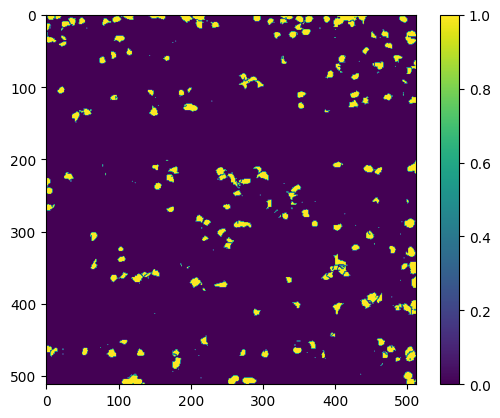

In [66]:
diffimg=(imread('/data/Devel_Human/GTmasks/15036.tif')>0)-combine_out_array(gt_mask)>0
plt.imshow(1-diffimg)
plt.colorbar()

In [70]:
import skimage.io
big_o=[]
cell_masks = []

m = (1-diffimg).astype(np.uint8)*255
msk_lbl = measure.label(m==255)
props = measure.regionprops_table(msk_lbl,m,properties=('label','area','bbox_area'))
big_o = props['label'][np.where(props['area']>100)]
small_o = props['label'][np.where(props['area']<10)]

for jj in range(1,msk_lbl.max()+1):
    if jj not in small_o:
        if jj not in big_o:
            cell_masks.append(msk_lbl==jj)

        else:
            # split            
            newlbl = label_watershed(msk_lbl==jj)
            for ll in range(1,newlbl.max()+1):
                cell_masks.append(newlbl==ll) 

mask = np.dstack(cell_masks)

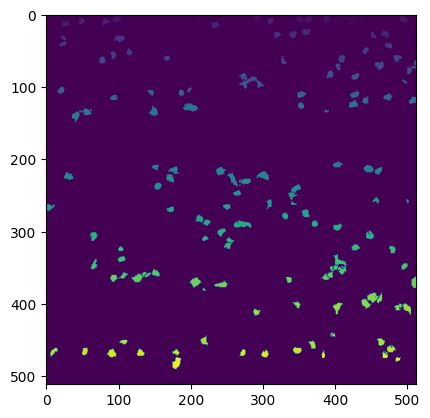

In [71]:
plt.imshow(combine_out_array(mask))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -150.00000  max:  200.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32


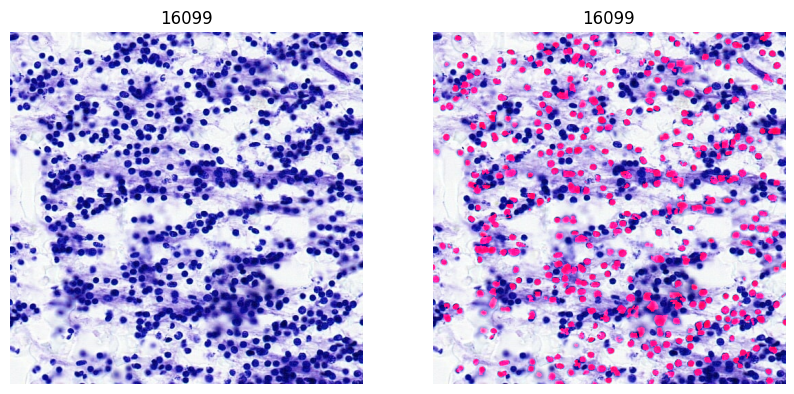

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -150.00000  max:  203.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32


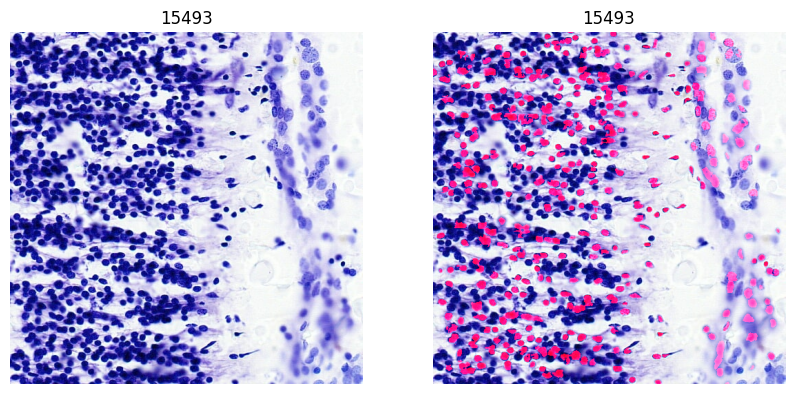

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -150.00000  max:  194.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32


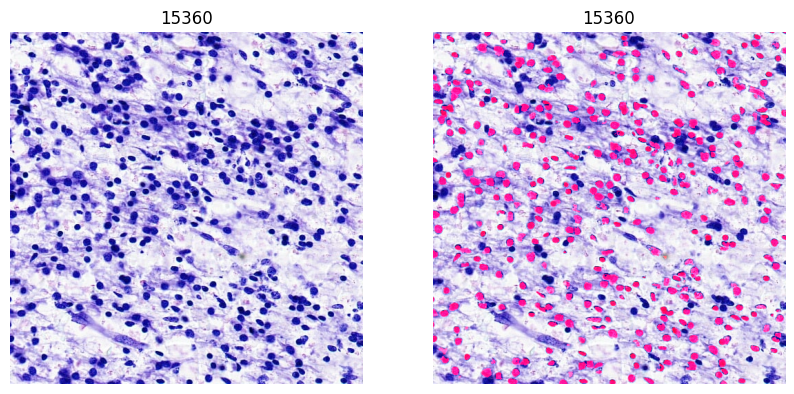

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -150.00000  max:  197.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32


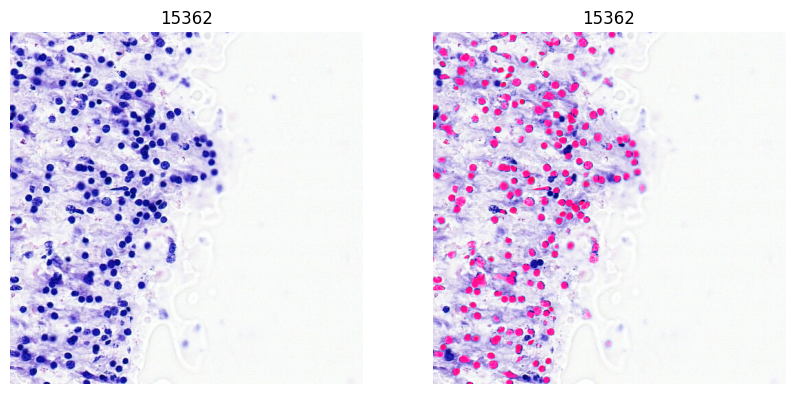

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -150.00000  max:  203.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32


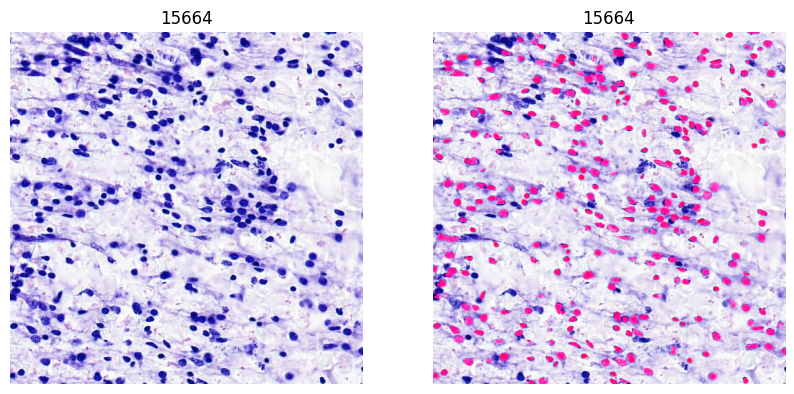

In [54]:
#For inference on images with GT masks
infer_dir='/data/samplefb10/'
for i,imgfile in enumerate(os.listdir(infer_dir)):
    orig_image=imread(os.path.join(infer_dir,imgfile))
    img_ = (255-orig_image)
    image_id=imgfile.split('.')[0] 
    r = model.detect([img_],verbose=1)
    out = r[0]['masks']
    display_annotated_cells(orig_image,out,image_id,save=False)
#     break

In [56]:
mAP_list=[]
precision_list=[]
recall_list=[]

for image_id in out_bboxes.keys():    
    out_mask=output_result[image_id]
    out_bbox=out_bboxes[image_id]
    gt_mask=gt_dict[image_id]
    gt_bbox=gt_bboxes[image_id]
    
#     print(out_mask.shape,gt_mask.shape,gt_bbox.shape,out_bbox.shape)
    mAP, precisions, recalls,overlaps_=compute_ap(gt_bbox, 1, gt_mask,out_bbox, 1, 1, out_mask, iou_threshold=0.01)
   
    mAP_list.append(mAP)
    
    precision=[x for x in precisions if x!=1.0]
    precision.sort()
    precision_list.append(precision[-1])
    
    recall=[x for x in recalls if x!=1.0]
    recall.sort()
    recall_list.append(recall[-1])

In [57]:
mAP_list[:10]

[0.9900662302970886,
 0.9523809552192688,
 0.9084858298301697,
 0.8873684028824647,
 0.7993845077645942,
 0.8926059581453915,
 1.0,
 0.9212089987340695,
 0.9441135340347523,
 0.884437620639801]

In [58]:
precision_list[:10]

[0.0,
 0.0,
 0.0,
 0.998371335504886,
 0.9983974358974359,
 0.9978991596638656,
 0.0,
 0.99800796812749,
 0.9979674796747967,
 0.0]

In [59]:
recall_list[:10]

[0.9900662302970886,
 0.9523809552192688,
 0.9084858298301697,
 0.887445867061615,
 0.799501895904541,
 0.8927911520004272,
 0.9960159659385681,
 0.9212453961372375,
 0.9442307949066162,
 0.884437620639801]

# DEMO

In [126]:
clubbed='clubbed_cell_sample'

In [79]:
path='/M28/Bhumika/DemoOutputs/'
if not os.path.exists(path):
    os.mkdir(path)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  240.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.00000  max:  130.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32


NameError: name 'save' is not defined

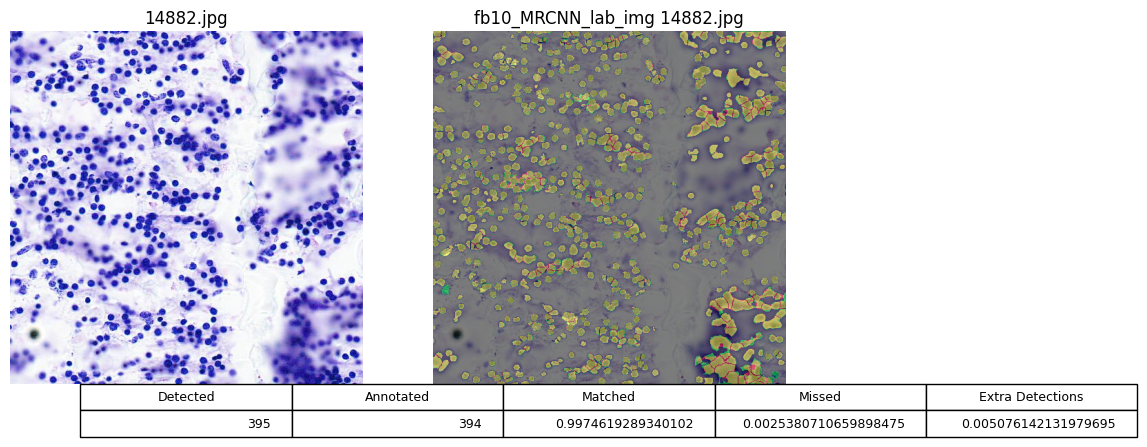

In [93]:
image_list=['14882.jpg']
mask_list=['14882.tif']
output_result={}
gt_dict = {}
gt_bboxes={}
out_bboxes={}
matched = []
annotated=[]
original_imgdir='/data/Devel_Human/Images/'
#for generic code without inverted images replace orig_image with img_
for i,imgfile in enumerate(image_list):
    orig_image=imread(os.path.join(original_imgdir,imgfile))
    img2d = imread(os.path.join(imgdir,imgfile))
    img_ = cv2.merge((img2d,img2d,img2d))
    image_id=imgfile.split('.')[0]
    gt_mask,_=load_mask(str(image_id))
    add_masks_to_dict(str(image_id),gt_mask,False)
    
    r = model.detect([img_],verbose=1)
    out = r[0]['masks']
    add_masks_to_dict(str(image_id),out,True)
#     print(out.shape[-1])
    
    gt_bboxes[str(image_id)]=extract_bboxes(gt_mask)
    out_bboxes[str(image_id)]=extract_bboxes(out)
    gt_match,pred_match,overlap_mat=compute_matches(gt_bboxes[str(image_id)],1,gt_mask,out_bboxes[str(image_id)],1,1,out,iou_threshold=0.01)
#     gt_match.shape,pred_match.shape             #Matches 
#     np.sum(gt_match==-1),np.sum(pred_match==-1) #Not Matched
    matched_cell_count = pred_match.shape[0]-np.sum(pred_match==-1) #Matched
    unmatched_cell_count =  np.sum(gt_match==-1)                #Missed
    extra_detection_count = np.sum(pred_match==-1)              #Extra Detection
    matched.append(matched_cell_count)
#     print(gt_match.shape,pred_match.shape,np.sum(gt_match==-1),np.sum(pred_match==-1))
    annotated.append(gt_mask.shape[-1])
    combined_out = combine_out_array(out)
    annot = imread(os.path.join(maskdir,mask_list[i]),plugin='pil')

    plt.figure(figsize=(10,10))
    
    plt.subplot(1,2,1)
    plt.title(imgfile)
    plt.axis('off')
    plt.imshow(orig_image)
    plt.subplot(1,2,2)
    plt.axis('off')
    tmp = np.dstack([(combined_out>0).astype(np.uint8)*255,(combine_out_array(gt_mask)>0).astype(np.uint8)*255,np.zeros_like(annot)])

#     imsave(os.path.join(outdir,imgfile),tmp)
    plt.title('fb10_MRCNN_lab_img '+imgfile)
    plt.imshow(tmp)
    plt.imshow(orig_image,alpha=0.5)
#     plt.imshow(combined_out>0,alpha=0.5)
    
    columns = ('Detected', 'Annotated', 'Matched','Missed','Extra Detections')
    cell_text = [[pred_match.shape[0],gt_mask.shape[-1],matched_cell_count/gt_mask.shape[-1],unmatched_cell_count/gt_mask.shape[-1],extra_detection_count/gt_mask.shape[-1]]] 
    the_table=plt.table(cellText=cell_text,
                      colLabels=columns,
                      loc='bottom')
    the_table.set_fontsize(15)
    the_table.scale(3, 3.5)
    if save:
        output_filename = os.path.join(out_dir, imgfile.split('.')[0] + '.jpg')
        plt.savefig(output_filename, format='jpg', bbox_inches='tight', dpi=300)
    plt.show()

    plt.close()
    display_annotated_cells(orig_image,out,image_id,save)
#     break

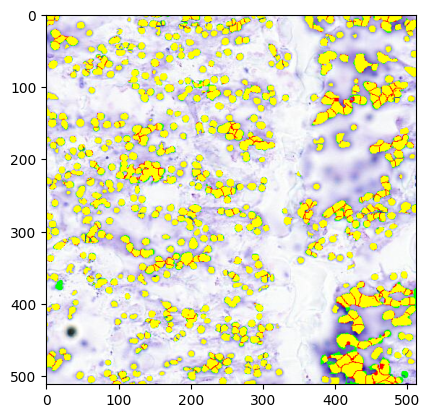

In [122]:
if tmp.shape != orig_image.shape:
    raise ValueError("Both images should have the same dimensions.")
black_pixel_mask = (tmp == [0, 0, 0]).all(axis=2)
image3 = tmp.copy()
image3[black_pixel_mask] = orig_image[black_pixel_mask]
plt.imshow(image3)

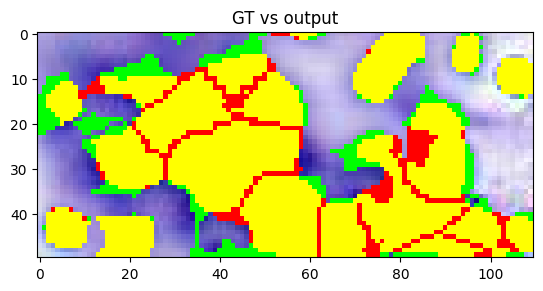

In [127]:
plt.imshow(image3[462:,380:490,:])
plt.title(r"GT vs output")
plt.savefig(path+clubbed+'14882_cropped_image_gt_vs_output.jpg')

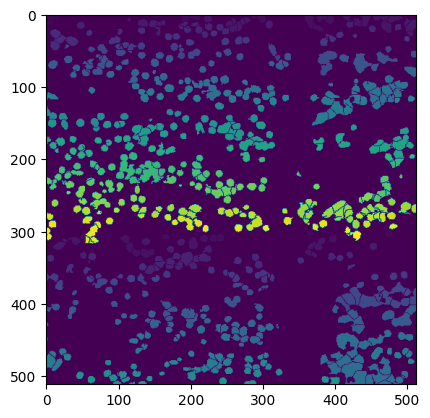

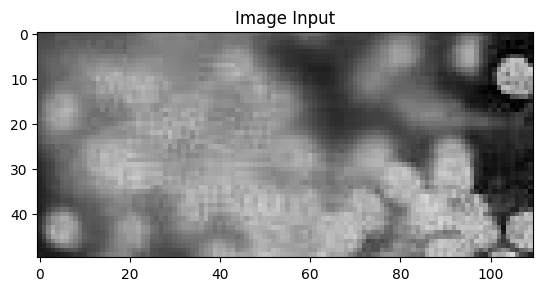

In [128]:
plt.imshow(img_[462:,380:490,:])
plt.title(r"Image Input")
plt.savefig(path+clubbed+'14882_cropped_imageinput.jpg')

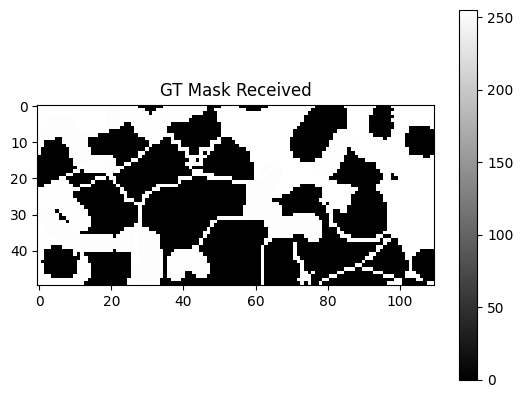

In [129]:
op_img_path=path+clubbed+'14882_cropped_GTmask_received.jpg'
plt.imshow(imread('/data/Devel_Human/GTmasks/14882.tif')[462:,380:490],cmap='gray')
plt.title('GT Mask Received')
plt.colorbar()
plt.savefig(op_img_path)

In [131]:
out.shape

(512, 512, 395)

In [133]:
def display_annotated_cells_(original_image, annotated_cells):
    # Create a copy of the original image
    import cv2
    display_image = original_image.copy()

    # Iterate over each annotated cell
    for i in range(annotated_cells.shape[2]):
        # Extract the binary annotation for the current cell
        cell_annotation = annotated_cells[:, :, i]

        # Create a boolean mask for the current cell annotation
        cell_mask = np.zeros_like(original_image[:, :, 0])
        cell_mask[cell_annotation > 0] = 255

        # Convert the mask to BGR color space
        cell_mask_bgr = cv2.cvtColor(cell_mask, cv2.COLOR_GRAY2BGR)

        # Set the red channel to maximum intensity (255)
        cell_mask_bgr[:, :, 0][cell_mask == 255] = 255
        cell_mask_bgr[:, :, 1][cell_mask == 255] = 0
        cell_mask_bgr[:, :, 2][cell_mask == 255] = 0
        # Add the cell mask to the display image
        display_image = cv2.add(display_image, cell_mask_bgr)
    
    return display_image

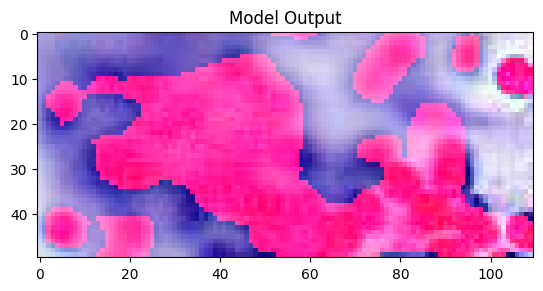

In [135]:
plt.imshow(display_annotated_cells_(orig_image,out)[462:,380:490])
plt.title('Model Output')
plt.savefig(path+clubbed+'14882_cropped_modeloutput_overlayed.jpg')

In [136]:
gt_mask,_=load_mask('14882')
mask_cropped_region=[]
for i in range(gt_mask.shape[-1]):
    mask_cropped=gt_mask[:,:,i][462:,380:490]
    if np.any(mask_cropped):
        mask_cropped_region.append(mask_cropped)
        

In [137]:
len(mask_cropped_region)

6

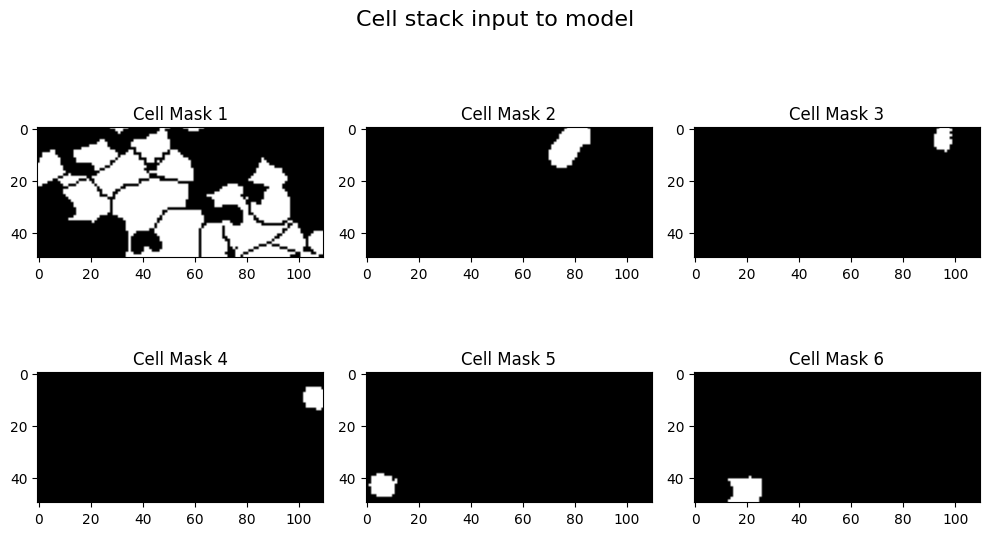

In [138]:
import matplotlib.pyplot as plt

# Create a list of images (replace this with your actual images)
image_list = mask_cropped_region

# Determine the number of rows and columns for the subplot grid
num_images = len(image_list)
num_rows = 2  # You can adjust the number of rows as needed
num_cols = (num_images + num_rows - 1) // num_rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

# Iterate through the list of images and display them in subplots
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(image_list[i], cmap='gray')  # Adjust cmap if images are color
        ax.set_title(f'Cell Mask {i+1}')  # Set subplot titles (optional)
    else:
        ax.axis('off')  # Turn off empty subplots
        
plt.suptitle("Cell stack input to model", fontsize=16)
plt.tight_layout()

# Show or save the subplot grid
plt.savefig(path+clubbed+"cell_masks_input_to_model.jpg")  
plt.show()
# To save the subplot grid as an image


In [243]:
import cv2
import numpy as np
color='green'
# Load the binary image (image1) and the RGB image (image2)
image1 = 255-imread('/data/Devel_Human/GTmasks/14882.tif')
image2 = orig_image
def overlay_binary_mask_on_original_image(binmask,bgimage,color):
# Create a mask from image1 where bright pixels are white (255) and dark pixels are black (0)
    mask = (binmask > 0).astype(np.uint8) * 255
#     print(mask.shape)
    # Convert the mask to a 3-channel image to match the shape of image2
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Create a yellow color mask with the same size as image2
    if color=='green':
        mask_color = np.full_like(bgimage, (0, 255, 0), dtype=np.uint8)
    if color=='red':
        mask_color = np.full_like(bgimage, (255, 0, 0), dtype=np.uint8)
    if color=='orange':
        mask_color = np.full_like(bgimage, (255, 20, 0), dtype=np.uint8)
    if color=='pink':
        mask_color = np.full_like(bgimage,(255,0,255), dtype=np.uint8) 

    colored_mask = cv2.bitwise_and(mask_color, mask_color, mask=mask)
    result = cv2.addWeighted(bgimage, 1, colored_mask, 1, 0)
    return result
# # Display or save the resultant image
# plt.imshow(overlay_binary_mask_on_original_image(image1,image2,'green')[462:,380:490])
# plt.title('GT Mask')
# plt.savefig(path+clubbed+'14882_cropped_GTmask_overlayed.jpg')

In [146]:
np.unique(image1[462:,380:490])
# plt.colorbar()

array([  0,   1,   2, 255], dtype=uint8)

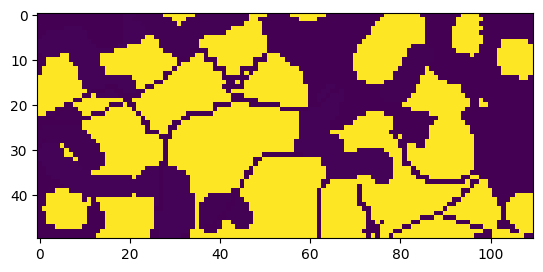

In [148]:
plt.imshow(image1[462:,380:490])

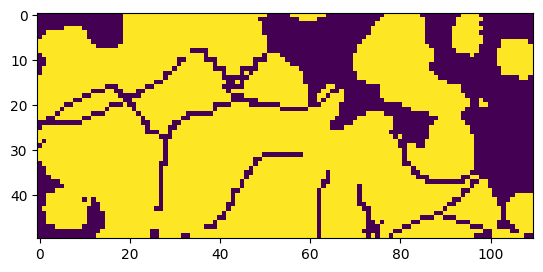

In [151]:
plt.imshow(image1[462:,380:490]>0)

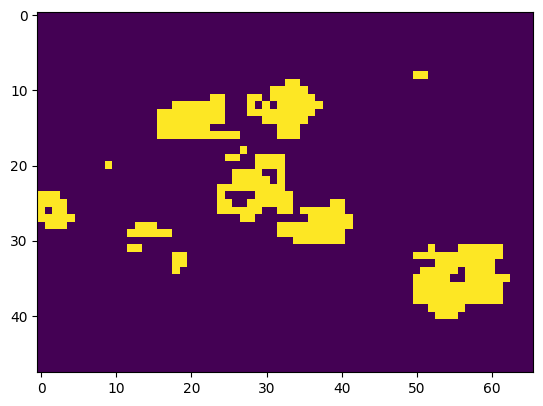

In [25]:
plt.imshow(combine_out_array(out)>0)

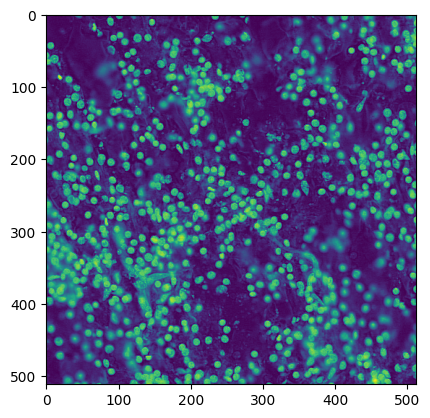

In [35]:
import cv2
import matplotlib.pyplot as plt

# Load the RGB image
rgb_image = cv2.imread("31549.png")

# Convert the RGB image to LAB color space using OpenCV
lab_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2Lab)

# Display the LAB image
plt.imshow(255-lab_image[:,:,0])


In [37]:
lab_inv_img=255-lab_image[:,:,0]

In [38]:
img_ = cv2.merge((lab_inv_img,lab_inv_img,lab_inv_img))
r = model.detect([img_],verbose=1)
out = r[0]['masks']

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.00000  max:  138.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.06262  max:    1.00000  float32


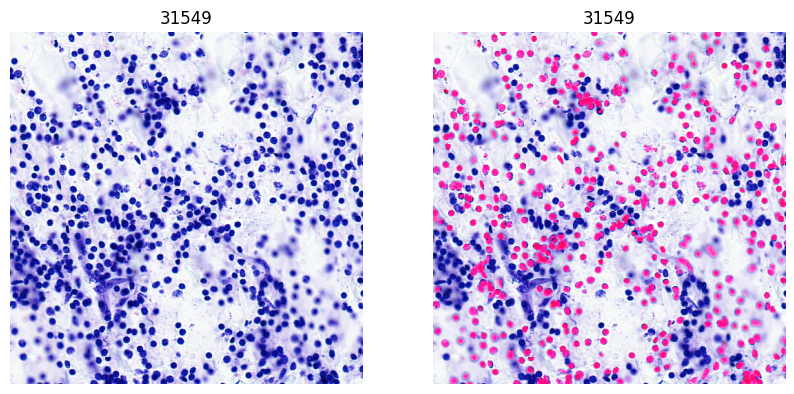

In [40]:
display_annotated_cells(imread('31549.png'),out,'31549',save=False)

# Hippocampus demo


In [216]:
orig_hippo_img=imread('/M28/mba_converted_imaging_data/MD806/Hippocampus_inference_data/2023.tif')
bin_mask_hippo_img=imread('/M28/mba_converted_imaging_data/MD806/Hippocampus_inference_data/MD806-N675-2020.01.28-18.40.12_MD806_1_2023_lossless.tif')

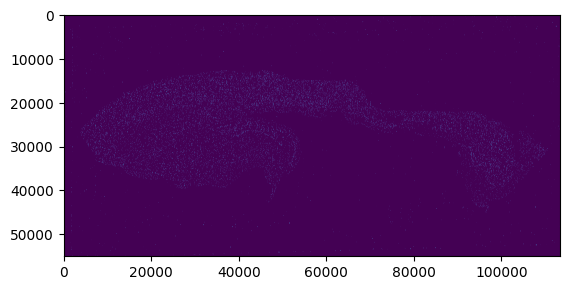

In [217]:
plt.imshow(bin_mask_hippo_img)

In [235]:
import os
import numpy as np
from PIL import Image
from math import floor
def tile_image(image,sz=512):
    fileExt='jp2'
    if len(image.shape)==3:
        h,w,c=image.shape
    if len(image.shape)==2:
        h,w=image.shape
    tiles={}
    for row in range(0, h, sz):
        for col in range(0, w, sz):
            if len(image.shape)==3:
                tile = image[row:min(row + sz, h), col:min(col + sz, w), :]
            if len(image.shape)==2:
                tile = image[row:min(row + sz, h), col:min(col + sz, w)]
#             maskT = mask[row:min(row + sz, w), col:min(col + sz, h)]
            tileName = str(floor(row/sz)+1) + "_" + str(floor(col/sz)+1) + "." + fileExt # fileName w/o fileExtension 
#             print(tileName)
            tiles[tileName]=tile
    return tiles
          
def restitch_tiles(tiles):
    # Extract tile size from the first tile
    first_tile_key = next(iter(tiles))
    first_tile = tiles[first_tile_key]
    tile_size = first_tile.shape[:2]  # Extract height and width dimensions

    # Calculate the dimensions of the original image
    max_row = max_col = 0
    for tile_key in tiles:
        row, col = map(int, tile_key[:-4].split('_')[:2])  # Extract row and column indices
        max_row = max(max_row, row)
        max_col = max(max_col, col)
    w = tile_size[1] * max_col
    h = tile_size[0] * max_row

    # Create an empty array for the restitched image
    if len(first_tile.shape)==3:
        restitched_image = np.zeros((h, w, 3), dtype=np.uint8)
    if len(first_tile.shape)==2:
        restitched_image = np.zeros((h, w) , dtype=np.uint8)
    # Iterate over each tile
    for tile_key in tiles:
        tile_array = tiles[tile_key]

        # Extract the tile position from the file name
        row, col = map(int, tile_key[:-4].split('_')[:2])  # Extract row and column indices

        # Calculate the pixel coordinates for the tile
        start_row = (row - 1) * tile_size[0]
        end_row = start_row + tile_array.shape[0]
        start_col = (col - 1) * tile_size[1]
        end_col = start_col + tile_array.shape[1]

        # Insert the tile into the restitched image array
        if len(first_tile.shape)==3:
            restitched_image[start_row:end_row, start_col:end_col, :] = tile_array
        if len(first_tile.shape)==2:
            restitched_image[start_row:end_row, start_col:end_col] = tile_array
    # Return the restitched image array
    return restitched_image


In [230]:
orig_hippo_img.shape

(55040, 113280, 3)

In [231]:
bin_mask_hippo_img.shape

(55040, 113280)

In [232]:
ORIGINAL_IMAGE_TILES=tile_image(orig_hippo_img)

In [237]:
len(ORIGINAL_IMAGE_TILES)==len(BINARY_MASK_TILES)

True

In [236]:
BINARY_MASK_TILES=tile_image(bin_mask_hippo_img)

In [239]:
ORIGINAL_IMAGE_TILES.keys()

dict_keys(['1_1.jp2', '1_2.jp2', '1_3.jp2', '1_4.jp2', '1_5.jp2', '1_6.jp2', '1_7.jp2', '1_8.jp2', '1_9.jp2', '1_10.jp2', '1_11.jp2', '1_12.jp2', '1_13.jp2', '1_14.jp2', '1_15.jp2', '1_16.jp2', '1_17.jp2', '1_18.jp2', '1_19.jp2', '1_20.jp2', '1_21.jp2', '1_22.jp2', '1_23.jp2', '1_24.jp2', '1_25.jp2', '1_26.jp2', '1_27.jp2', '1_28.jp2', '1_29.jp2', '1_30.jp2', '1_31.jp2', '1_32.jp2', '1_33.jp2', '1_34.jp2', '1_35.jp2', '1_36.jp2', '1_37.jp2', '1_38.jp2', '1_39.jp2', '1_40.jp2', '1_41.jp2', '1_42.jp2', '1_43.jp2', '1_44.jp2', '1_45.jp2', '1_46.jp2', '1_47.jp2', '1_48.jp2', '1_49.jp2', '1_50.jp2', '1_51.jp2', '1_52.jp2', '1_53.jp2', '1_54.jp2', '1_55.jp2', '1_56.jp2', '1_57.jp2', '1_58.jp2', '1_59.jp2', '1_60.jp2', '1_61.jp2', '1_62.jp2', '1_63.jp2', '1_64.jp2', '1_65.jp2', '1_66.jp2', '1_67.jp2', '1_68.jp2', '1_69.jp2', '1_70.jp2', '1_71.jp2', '1_72.jp2', '1_73.jp2', '1_74.jp2', '1_75.jp2', '1_76.jp2', '1_77.jp2', '1_78.jp2', '1_79.jp2', '1_80.jp2', '1_81.jp2', '1_82.jp2', '1_83.jp2', '1

In [238]:
BINARY_MASK_TILES.keys()

dict_keys(['1_1.jp2', '1_2.jp2', '1_3.jp2', '1_4.jp2', '1_5.jp2', '1_6.jp2', '1_7.jp2', '1_8.jp2', '1_9.jp2', '1_10.jp2', '1_11.jp2', '1_12.jp2', '1_13.jp2', '1_14.jp2', '1_15.jp2', '1_16.jp2', '1_17.jp2', '1_18.jp2', '1_19.jp2', '1_20.jp2', '1_21.jp2', '1_22.jp2', '1_23.jp2', '1_24.jp2', '1_25.jp2', '1_26.jp2', '1_27.jp2', '1_28.jp2', '1_29.jp2', '1_30.jp2', '1_31.jp2', '1_32.jp2', '1_33.jp2', '1_34.jp2', '1_35.jp2', '1_36.jp2', '1_37.jp2', '1_38.jp2', '1_39.jp2', '1_40.jp2', '1_41.jp2', '1_42.jp2', '1_43.jp2', '1_44.jp2', '1_45.jp2', '1_46.jp2', '1_47.jp2', '1_48.jp2', '1_49.jp2', '1_50.jp2', '1_51.jp2', '1_52.jp2', '1_53.jp2', '1_54.jp2', '1_55.jp2', '1_56.jp2', '1_57.jp2', '1_58.jp2', '1_59.jp2', '1_60.jp2', '1_61.jp2', '1_62.jp2', '1_63.jp2', '1_64.jp2', '1_65.jp2', '1_66.jp2', '1_67.jp2', '1_68.jp2', '1_69.jp2', '1_70.jp2', '1_71.jp2', '1_72.jp2', '1_73.jp2', '1_74.jp2', '1_75.jp2', '1_76.jp2', '1_77.jp2', '1_78.jp2', '1_79.jp2', '1_80.jp2', '1_81.jp2', '1_82.jp2', '1_83.jp2', '1

In [246]:
def show_images_side_by_side(image1, image2,img_name):
    print(img_name)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots

    # Plot the first image
    ax[0].imshow(image1)
    ax[0].axis('off')

    # Plot the second image
    ax[1].imshow(image2,cmap='gray')
    ax[1].axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1)

    # Display the figure
    plt.savefig('/M28/Bhumika/DemoOutputs/HippocampusTiles/'+img_name+'.jpg')
    plt.show()

In [247]:
imglist=['41_41','47_47',
'50_50',
'52_52',
'56_56',
'60_56',

'65_101',

'65_96',
'80_56']

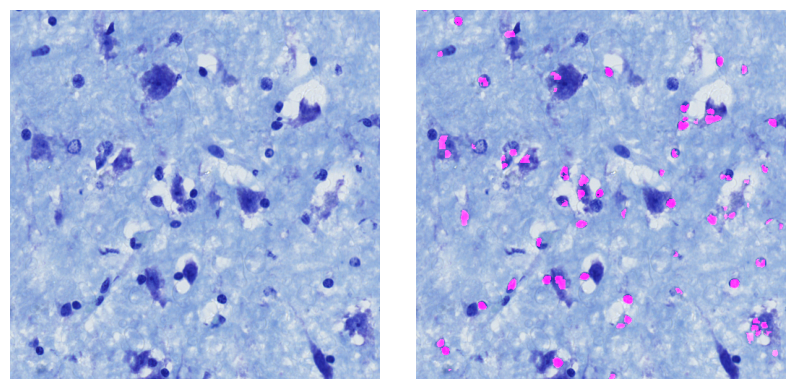

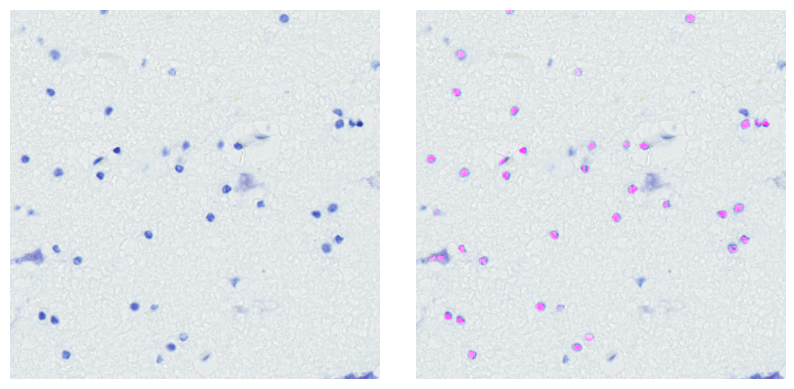

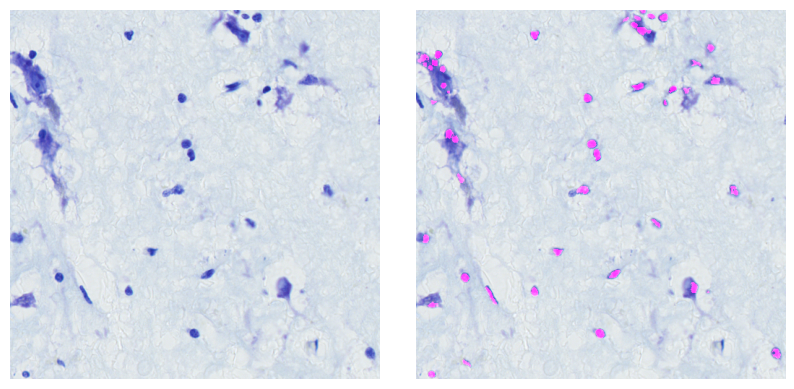

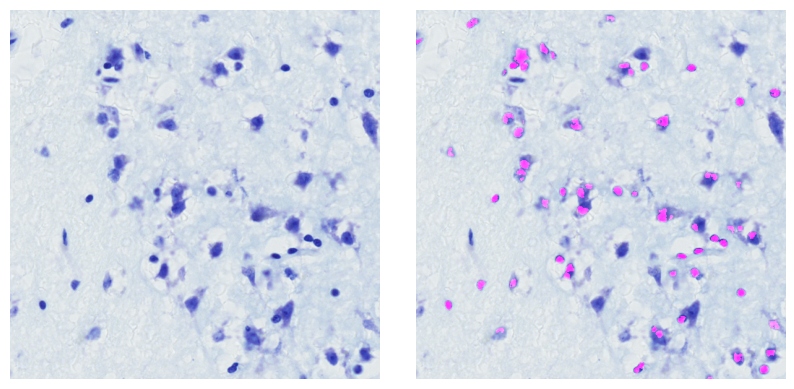

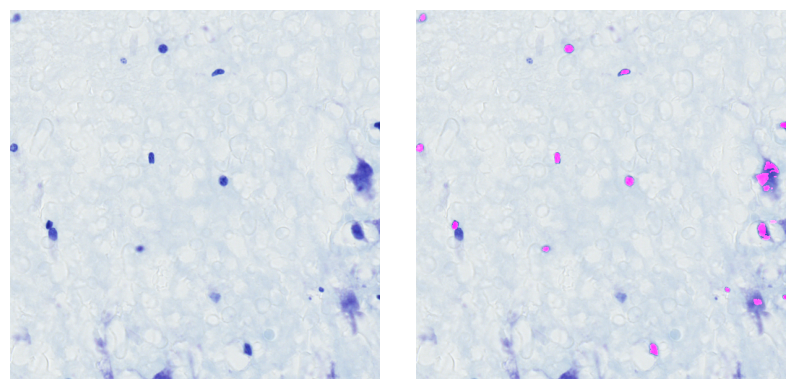

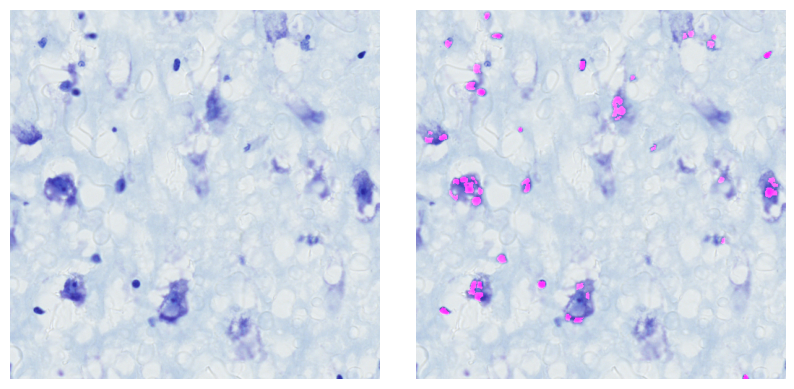

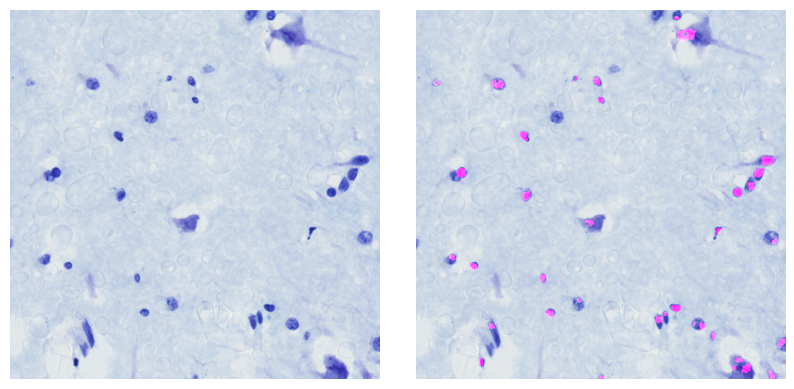

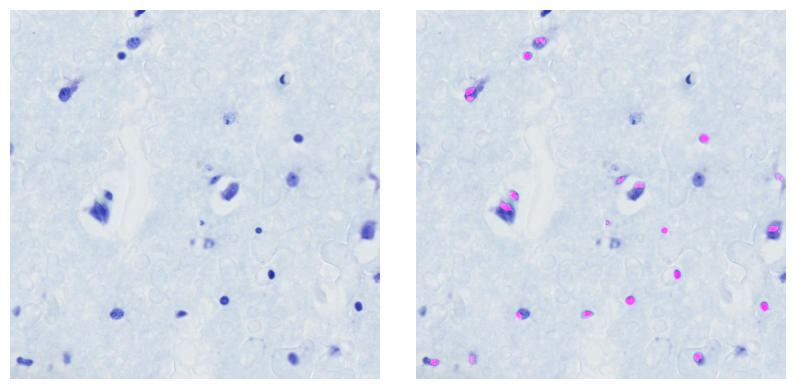

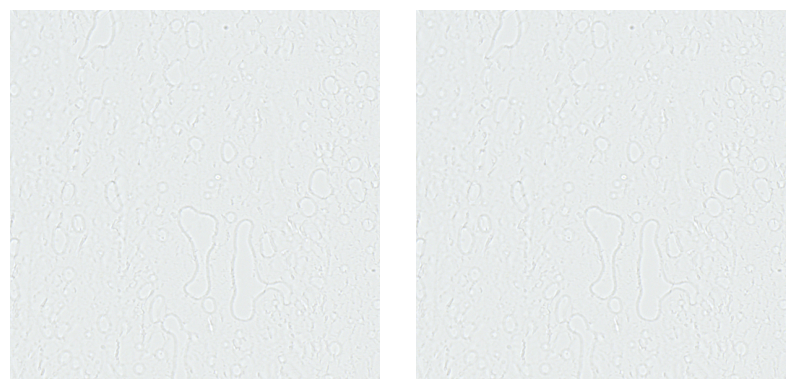

In [249]:
for img_name in imglist:
    show_images_side_by_side(ORIGINAL_IMAGE_TILES[img_name+'.jp2'],
                            overlay_binary_mask_on_original_image(BINARY_MASK_TILES[img_name+'.jp2'],ORIGINAL_IMAGE_TILES[img_name+'.jp2'],color='pink'),
                            img_name)
#     break

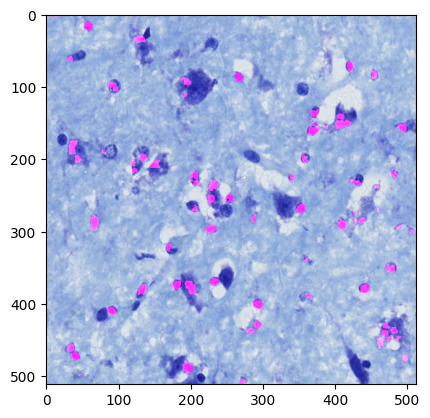

In [245]:
overlay_binary_mask_on_original_image(BINARY_MASK_TILES[img_name+'.jp2'],ORIGINAL_IMAGE_TILES[img_name+'.jp2'],color='pink'))